<a href="https://colab.research.google.com/github/Srivanireddy15/Customer-Segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

data = pd.read_csv('/content/marketing_campaign.csv', sep='\t');

# Data Cleaning
if(data.isnull().any().any()):
  list_cols = data.columns[data.isnull().any()]

for col in list_cols:
  mean_val = data[col].mean()
  data[col] = data[col].fillna(mean_val)

print(data.columns)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


In [2]:
from datetime import date
# Feature Engineering
# Transforming raw features into meaningful insights
# We want to make the analysis based on customer behavior, demographics and engagement

new_data = pd.DataFrame()

# Customer Behavior: Spending behavior
new_data['TotalSpent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

#  Demographics
new_data['Age'] = 2025 - data['Year_Birth']
new_data['Children'] = data['Kidhome'] + data['Teenhome']
new_data['Income'] = data['Income']
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y').dt.date
new_data['Tenure'] = (pd.to_datetime('today') - pd.to_datetime(data['Dt_Customer'])).dt.days

# Engagement
new_data['AcceptedCmp'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5']
new_data['Total_Purchases'] = data['NumDealsPurchases'] + data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases']
new_data['Complain'] = data['Complain']
new_data['Response'] = data['Response']

print(new_data.columns)

Index(['TotalSpent', 'Age', 'Children', 'Income', 'Tenure', 'AcceptedCmp',
       'Total_Purchases', 'Complain', 'Response'],
      dtype='object')


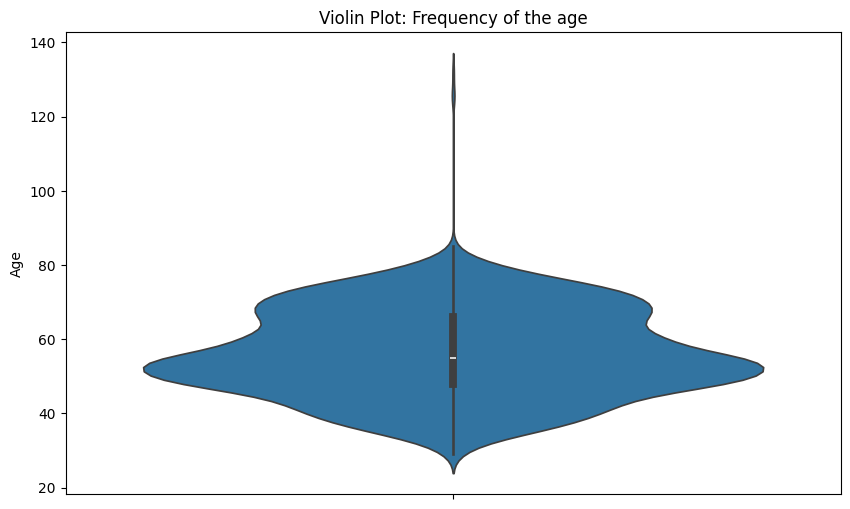

In [3]:
# violin plot: Combination of box plot and kernel density plot
# Plot to know the age and it's frequency
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
plt.title("Violin Plot: Frequency of the age")
sns.axes_style("dark")
sns.violinplot(y=new_data["Age"])
plt.show()

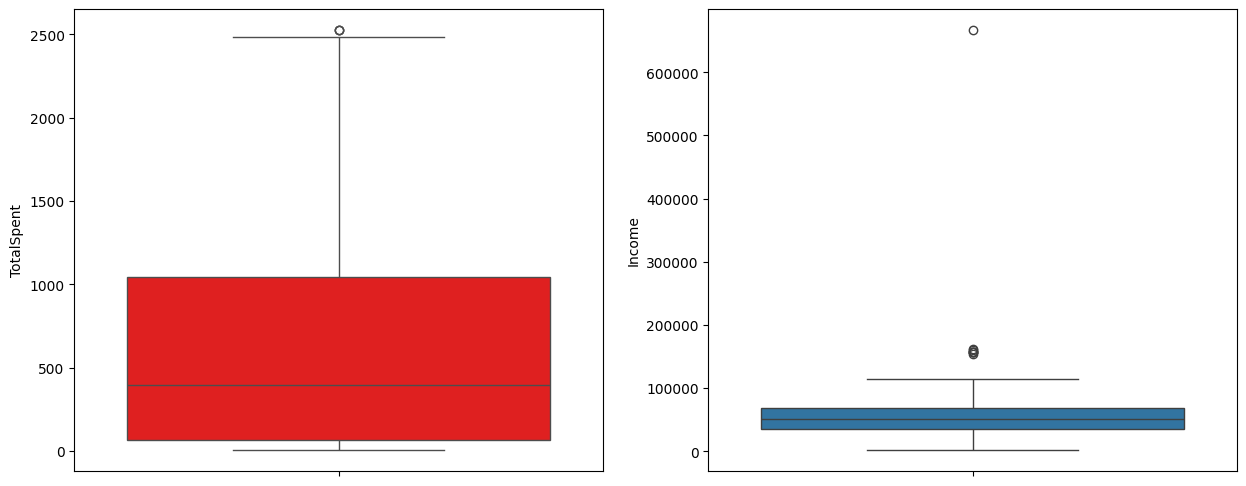

In [4]:
# box-plot of annual income and expenses
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot(y=new_data["TotalSpent"], color="red")
plt.subplot(1,2,2)
sns.boxplot(y=new_data["Income"])
plt.show()

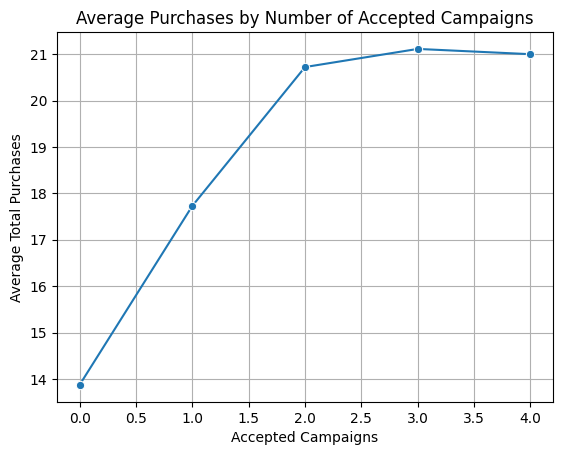

In [5]:
# Line graph between the Accepted Campaigns and Total Purchases
avg_purchase = new_data.groupby('AcceptedCmp')['Total_Purchases'].mean().reset_index()

sns.lineplot(data=avg_purchase, x='AcceptedCmp', y='Total_Purchases', marker='o')
plt.title("Average Purchases by Number of Accepted Campaigns")
plt.xlabel("Accepted Campaigns")
plt.ylabel("Average Total Purchases")
plt.grid(True)
plt.show()

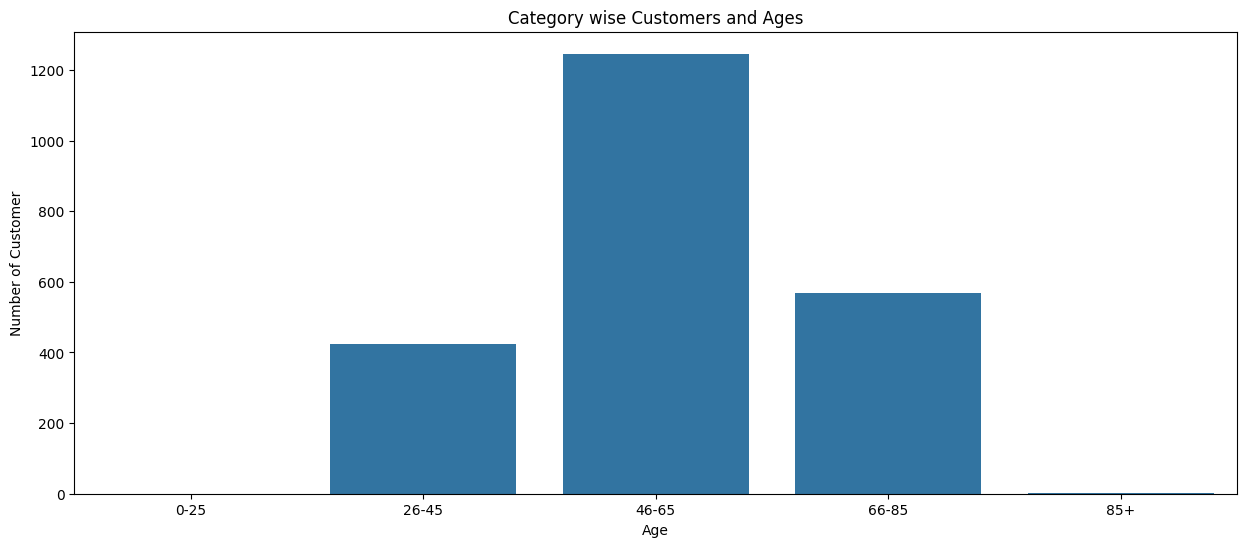

In [6]:
# Bar Plot Classifying the customers into different age categories

age0_25 = new_data.Age[(new_data.Age <= 25) & (new_data.Age >= 0)]
age26_45 = new_data.Age[(new_data.Age <= 45) & (new_data.Age >= 26)]
age46_65 = new_data.Age[(new_data.Age <= 65) & (new_data.Age >= 46)]
age66_85 = new_data.Age[(new_data.Age <= 85) & (new_data.Age >= 66)]
age85above = new_data.Age[new_data.Age >= 86]

x = ["0-25","26-45","46-65","66-85","85+"]
y = [len(age0_25.values),len(age26_45.values),len(age46_65.values),len(age66_85.values),len(age85above.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y)
plt.title("Category wise Customers and Ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")
plt.show()

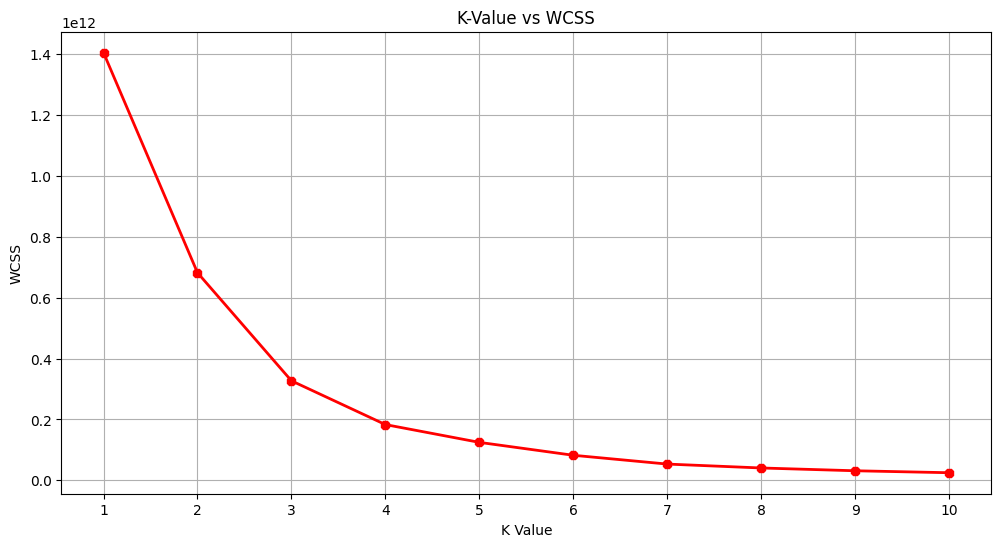

In [7]:
# WCSS - Within-Cluster Sum of Squares
# Plot between the cluster value and WCSS on a range of 1 to 10

from sklearn.cluster import KMeans
import numpy as np

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(new_data.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,11), wcss, linewidth=2, color="red", marker ="8")
plt.title('K-Value vs WCSS')
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

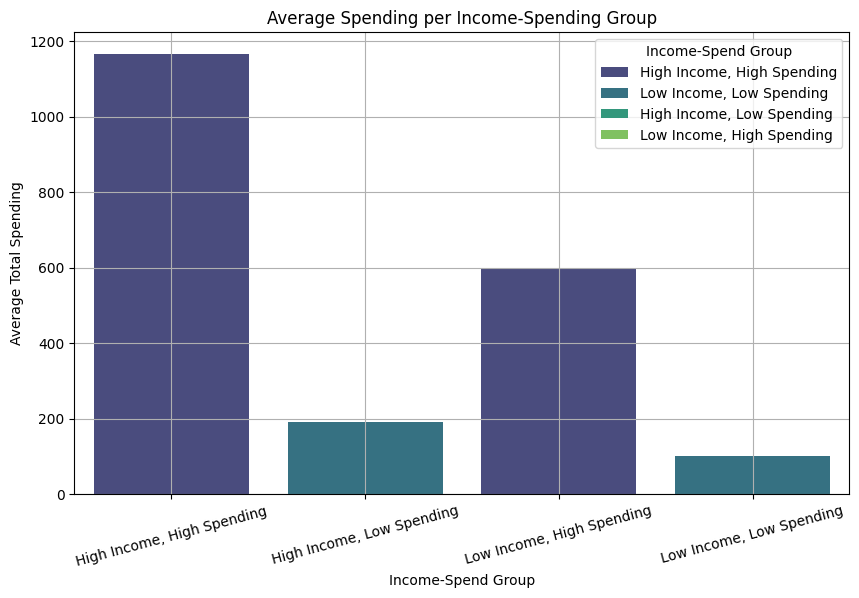

In [8]:
# Group customers based on their Spending nature
# Category-1: High Income, High Spending
# Category-2: High Income Low Spending
# Category-3: Low Income High Spending
# Category-4: Low Income Low Spending

#Plot graph between each category and the amount they sepnt

def spending_income_group(row):
    if row['Income'] >= income_median and row['TotalSpent'] >= spend_median:
        return 'High Income, High Spending'
    elif row['Income'] >= income_median and row['TotalSpent'] < spend_median:
        return 'High Income, Low Spending'
    elif row['Income'] < income_median and row['TotalSpent'] >= spend_median:
        return 'Low Income, High Spending'
    else:
        return 'Low Income, Low Spending'

IncomeSpendGroup = pd.DataFrame()
IncomeSpendGroup['Income'] = new_data['Income']
IncomeSpendGroup['TotalSpent'] = new_data['TotalSpent']
income_median = IncomeSpendGroup['Income'].median()
spend_median = IncomeSpendGroup['TotalSpent'].median()
IncomeSpendGroup['Income-Spend Group'] = IncomeSpendGroup.apply(spending_income_group, axis=1)

group_avg = IncomeSpendGroup.groupby('Income-Spend Group')[['Income', 'TotalSpent']].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=group_avg, x='Income-Spend Group', y='TotalSpent', hue=IncomeSpendGroup['Income-Spend Group'], palette='viridis')
plt.title('Average Spending per Income-Spending Group')
plt.ylabel('Average Total Spending')
plt.xticks(rotation=15)
plt.grid(True)
plt.show()

In [9]:
# One-hot encoding of Education and Marital Status

df = pd.DataFrame({
    'Education': data['Education'],
    'Marital_Status': data['Marital_Status']
})


categorical_columns = ['Education', 'Marital_Status']

encoded_df = pd.DataFrame()

for col in categorical_columns:

    unique_vals = df[col].unique()

    for val in unique_vals:
        encoded_col_name = f"{col}_{val}"
        encoded_df[encoded_col_name] = (df[col] == val).astype(int)

df_encoded = pd.concat([df.drop(categorical_columns, axis=1), encoded_df], axis=1)

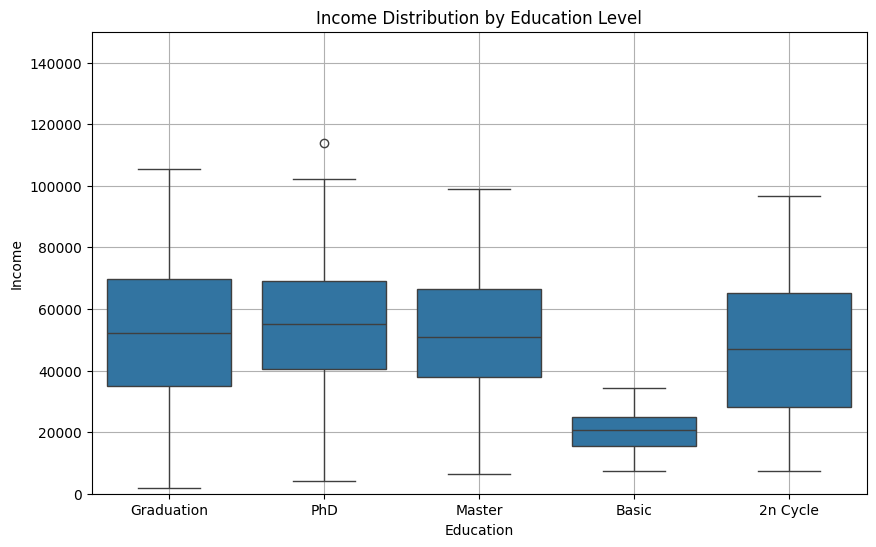

In [10]:
# Plot between Education Level and Income

education_cols = ['Education_PhD', 'Education_Master', 'Education_Basic', 'Education_Graduation', 'Education_2n Cycle']
education_labels = df_encoded[education_cols].idxmax(axis=1).str.replace('Education_', '')


plt.figure(figsize=(10,6))
sns.boxplot(data=new_data, x=education_labels, y='Income')
plt.title('Income Distribution by Education Level')
plt.xlabel('Education')
plt.ylabel('Income')
plt.ylim(0, 150000)
plt.grid(True)
plt.show()

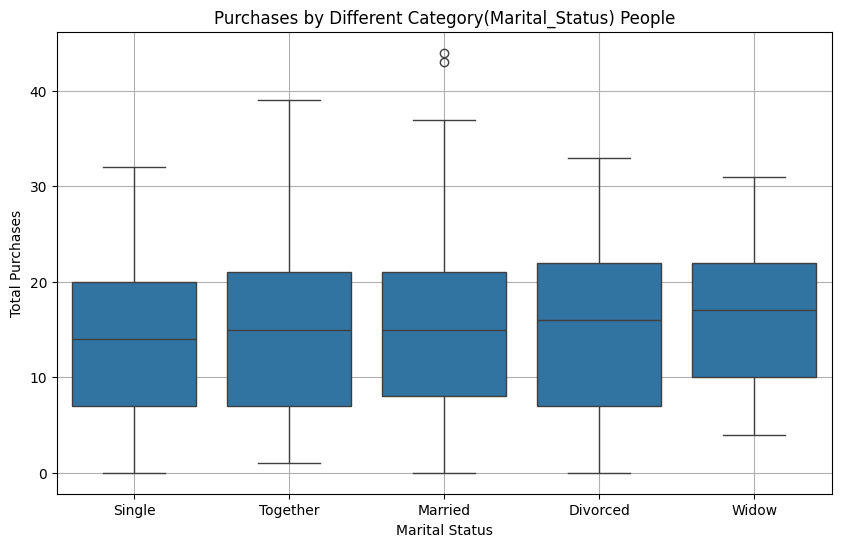

In [11]:
# Plot between Marital Status and Total Purchases

marital_cols = ['Marital_Status_Single', 'Marital_Status_Together', 'Marital_Status_Married', 'Marital_Status_Divorced', 'Marital_Status_Widow']
Marital_Status_Reconstructed = df_encoded[marital_cols].idxmax(axis=1).str.replace('Marital_Status_', '')

plt.figure(figsize=(10,6))
sns.boxplot(data=new_data, x=Marital_Status_Reconstructed, y='Total_Purchases')
plt.title('Purchases by Different Category(Marital_Status) People')
plt.xlabel('Marital Status')
plt.ylabel('Total Purchases')
plt.grid(True)
plt.show()

Complain
0    2219
1      21
Name: count, dtype: int64


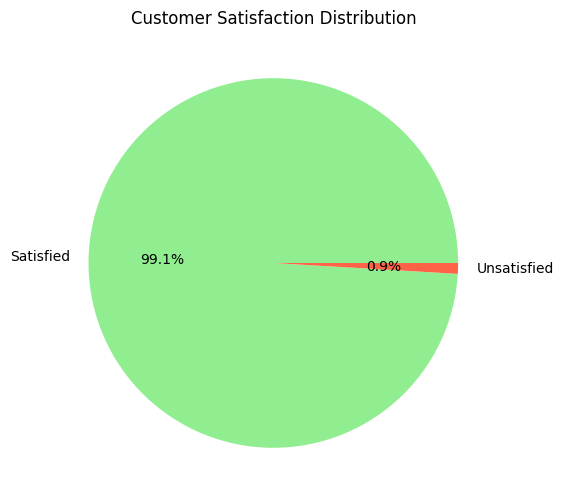

In [12]:
# Pie chart to know how many customers are satisfied based on their complains

satisfaction_counts = new_data['Complain'].value_counts()
print(satisfaction_counts)
labels = ['Satisfied', 'Unsatisfied']

plt.figure(figsize=(6,6))
plt.pie(satisfaction_counts, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'tomato'])
plt.title('Customer Satisfaction Distribution')
plt.show()


In [13]:
complained_and_responded = data[(data['Complain'] == 1) & (data['Response'] == 1)]
print(f"Customers who complained and later responded positively: {len(complained_and_responded)}")

Customers who complained and later responded positively: 3


In [14]:
complaint_response_summary = data.groupby(['Complain', 'Response']).size().reset_index(name='Count')
print(complaint_response_summary)

   Complain  Response  Count
0         0         0   1888
1         0         1    331
2         1         0     18
3         1         1      3


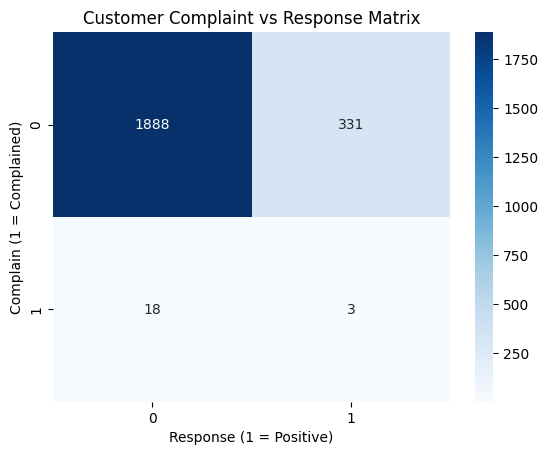

In [15]:
pivot = complaint_response_summary.pivot(index='Complain', columns='Response', values='Count')
sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.title("Customer Complaint vs Response Matrix")
plt.xlabel("Response (1 = Positive)")
plt.ylabel("Complain (1 = Complained)")
plt.show()

<ipython-input-16-98b8e0c0fc27>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=IncomeSpendGroup, x='Income-Spend Group', y='Complain', estimator='mean', palette='Set2')


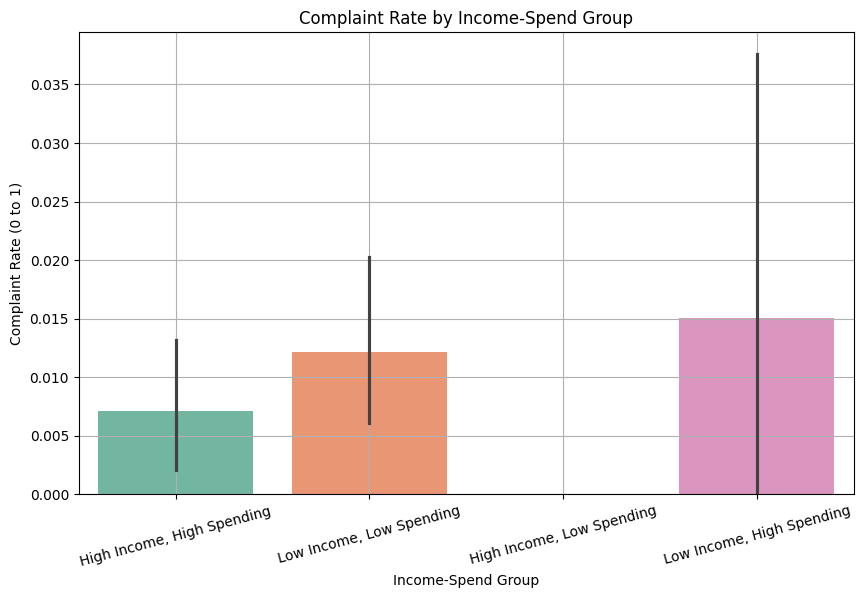

In [16]:
IncomeSpendGroup['Complain'] = new_data['Complain']

plt.figure(figsize=(10,6))
sns.barplot(data=IncomeSpendGroup, x='Income-Spend Group', y='Complain', estimator='mean', palette='Set2')

plt.title("Complaint Rate by Income-Spend Group")
plt.ylabel("Complaint Rate (0 to 1)")
plt.xticks(rotation=15)
plt.grid(True)
plt.show()

Converged in 30 iterations


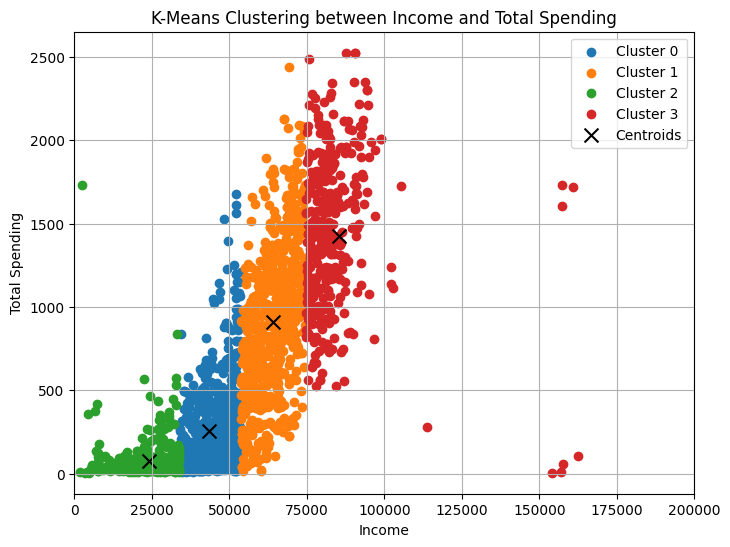

In [17]:
#K-Means between Income and Total Spent

X = new_data[['Income', 'TotalSpent']].values

k = 4
max_iters = 100
tol = 1e-4

np.random.seed(42)
initial_idx = np.random.choice(len(X), size=k, replace=False)
centroids = X[initial_idx]

for i in range(max_iters):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

    if np.all(np.abs(new_centroids - centroids) < tol):
        break
    centroids = new_centroids

print(f"Converged in {i+1} iterations")

plt.figure(figsize=(8,6))
for j in range(k):
    plt.scatter(X[labels == j, 0], X[labels == j, 1], label=f'Cluster {j}')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
plt.xlabel('Income')
plt.ylabel('Total Spending')
plt.xlim(0, 200000)
plt.title('K-Means Clustering between Income and Total Spending')
plt.legend()
plt.grid(True)
plt.show()

**Green Cluster:** Less Income and Less Spending

**Blue Cluster:** Moderate Income and Majority are less spending

**Orange Cluster:** Good Income and Moderate Spending

**Red Income:** High Income and High Spending.

Converged in 6 iterations


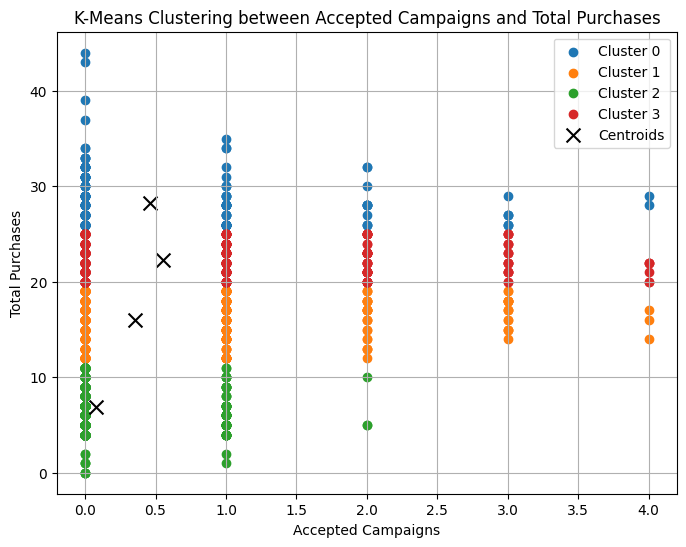

In [18]:
#K-Means between Accepted Campaigns and Total Purchases

X = new_data[['AcceptedCmp', 'Total_Purchases']].values

k = 4
max_iters = 100
tol = 1e-4

np.random.seed(42)
initial_idx = np.random.choice(len(X), size=k, replace=False)
centroids = X[initial_idx]

for i in range(max_iters):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

    if np.all(np.abs(new_centroids - centroids) < tol):
        break
    centroids = new_centroids

print(f"Converged in {i+1} iterations")

plt.figure(figsize=(8,6))
for j in range(k):
    plt.scatter(X[labels == j, 0], X[labels == j, 1], label=f'Cluster {j}')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
plt.xlabel('Accepted Campaigns')
plt.ylabel('Total Purchases')
plt.title('K-Means Clustering between Accepted Campaigns and Total Purchases')
plt.legend()
plt.grid(True)
plt.show()

**Green Cluster:** Made very less(Poor) purchases

**Orange Cluster:** Below Average Purchases

**Red Cluster:** Average Purchases

**Blue Cluster:** High Purchases

In [19]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
new_data = pd.DataFrame(scaler.fit_transform(new_data), columns=new_data.columns)

print(new_data[:5])

   TotalSpent       Age  Children    Income    Tenure  AcceptedCmp  \
0    1.679417  0.985345 -1.264505  0.235327  1.531185    -0.439037   
1   -0.961275  1.235733  1.396361 -0.235826 -1.190545    -0.439037   
2    0.282673  0.317643 -1.264505  0.773633 -0.205773    -0.439037   
3   -0.918094 -1.268149  0.065928 -1.022732 -1.061881    -0.439037   
4   -0.305254 -1.017761  0.065928  0.241519 -0.953012    -0.439037   

   Total_Purchases  Complain  Response  
0         1.320826 -0.097282  2.388846  
1        -1.154596 -0.097282 -0.418612  
2         0.799685 -0.097282 -0.418612  
3        -0.894025 -0.097282 -0.418612  
4         0.539114 -0.097282 -0.418612  


        PC1       PC2
0  2.726995 -0.668092
1 -1.881560  1.171368
2  1.012249  0.845273
3 -1.858230 -0.679429
4 -0.284496  0.230383


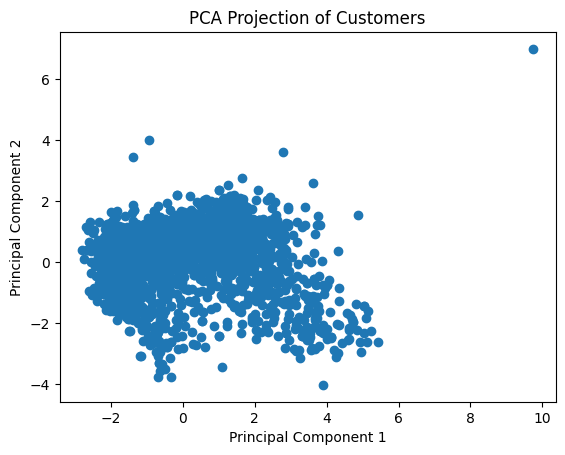

In [20]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(new_data), columns=['PC1', 'PC2'])

print(pca_data[:5])

plt.scatter(pca_data['PC1'], pca_data['PC2'])
plt.title("PCA Projection of Customers")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Converged in 16 iterations


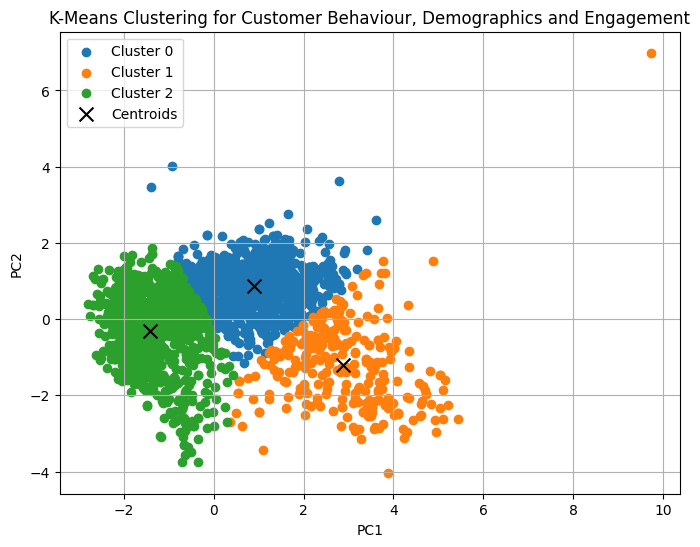

In [21]:
#K-Means between all the features of reduced new_data (pca_data) between demographics, customer behaviour and engagement

X = pca_data[['PC1', 'PC2']].values

k = 3
max_iters = 100
tol = 1e-4

np.random.seed(42)
initial_idx = np.random.choice(len(X), size=k, replace=False)
centroids = X[initial_idx]

for i in range(max_iters):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

    if np.all(np.abs(new_centroids - centroids) < tol):
        break
    centroids = new_centroids

print(f"Converged in {i+1} iterations")


plt.figure(figsize=(8,6))
for j in range(k):
    plt.scatter(X[labels == j, 0], X[labels == j, 1], label=f'Cluster {j}')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
plt.title('K-Means Clustering for Customer Behaviour, Demographics and Engagement')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

**Blue Cluster:** Balanced Customer, moderate income and high engagement customers.

**Orange Cluster:** Low engagement customers.

**Green Cluster:** Budget Conscious but responsive customers.